step_1

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import os

# ----------------------
# 1. 核心配置
# ----------------------
CONFIG = {
    "num_classes": 4,          # 4类
    "img_size": 256,           # Swin V2 Tiny 分辨率
    "batch_size": 32,          # 显存够大可以改 64
    "data_dir": "D:/IT/CODE/JUPYTER/ConvNeXt_V2/data", # 你的路径
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"当前配置: {CONFIG['num_classes']} 分类, 运行设备: {CONFIG['device']}")

# ----------------------
# 2. 数据增强 (升级版)
# ----------------------

# 【训练集】强数据增强
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG['img_size'], scale=(0.8, 1.0)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 【验证集 & 测试集】普通处理 (只缩放，不乱动)
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ----------------------
# 3. 数据加载
# ----------------------
# 加载两次：一次为了训练(强增强)，一次为了验证/测试(标准处理)
full_train_ds = datasets.ImageFolder(root=CONFIG['data_dir'], transform=train_transforms)
full_val_ds = datasets.ImageFolder(root=CONFIG['data_dir'], transform=val_transforms)

# 打印类别映射
print("类别映射:", full_train_ds.class_to_idx)

# ----------------------
# 4. 划分训练集、验证集、测试集 (8:1:1)
# ----------------------
# 计算数量
total_len = len(full_train_ds)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len # 剩下的给测试集

# 设定种子确保切分一致
seed = torch.Generator().manual_seed(42)

# A. 切出训练集 (使用 full_train_ds，带强增强)
train_dataset, _, _ = random_split(full_train_ds, [train_len, val_len, test_len], generator=seed)

seed = torch.Generator().manual_seed(42) # 重置种子，位置对齐

# B. 切出验证集和测试集 (使用 full_val_ds，带标准处理)
_, val_dataset, test_dataset = random_split(full_val_ds, [train_len, val_len, test_len], generator=seed)

# ----------------------
# 5. 创建加载器
# ----------------------
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
# 测试集用于最后写报告，不需要 shuffle
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ 数据加载完毕！")
print(f"训练集: {len(train_dataset)} (强增强)")
print(f"验证集: {len(val_dataset)} (标准)")
print(f"测试集: {len(test_dataset)} (标准 - 用于最终报告)")

当前配置: 4 分类, 运行设备: cuda
类别映射: {'class 0': 0, 'class 1': 1, 'class 2': 2, 'class 3': 3}
✅ 数据加载完毕！
训练集: 4940 (强增强)
验证集: 1058 (标准)
测试集: 1060 (标准 - 用于最终报告)


step_2

In [4]:
import timm
import torch
from peft import LoraConfig, get_peft_model

# ----------------------
# Step 2: 定义 LoRA 模型
# ----------------------
def get_lora_model(num_classes):
    print(f"正在构建 Swin V2 + LoRA 模型 (Class={num_classes})...")
    
    # 1. 加载基础模型 (预训练必须开启)
    base_model = timm.create_model(
        'swinv2_tiny_window16_256', 
        pretrained=True, 
        num_classes=num_classes
    )
    
    # 2. 配置 LoRA
    # target_modules: 针对 Swin 的注意力层进行微调
    # modules_to_save=["head"]: 【关键】分类头必须完全解冻，因为它要适应你的4分类
    peft_config = LoraConfig(
        r=16,             # 秩大小，控制参数量
        lora_alpha=16,    # 缩放系数
        target_modules=["qkv", "proj", "fc1", "fc2"], 
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["head"] 
    )
    
    # 3. 包装模型
    model = get_peft_model(base_model, peft_config)
    
    # 打印一下我们只训练了多少参数
    model.print_trainable_parameters()
    
    model = model.to(CONFIG['device'])
    return model

# 初始化模型
model = get_lora_model(CONFIG['num_classes'])

d:\IT\CONDA\envs\SV2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在构建 Swin V2 + LoRA 模型 (Class=4)...
trainable params: 1,135,876 || all params: 28,717,106 || trainable%: 3.9554


step_3

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys

# ----------------------
# 1. 准备训练工具 (LoRA 版)
# ----------------------
# 使用标签平滑，增加模型泛化能力
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 【关键修改】LoRA 的参数很少，学习率需要大一点，通常用 1e-3 或 5e-4
# 原来的 1e-5 对 LoRA 来说太小了，会导致收敛不动
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# 调度器 (余弦退火)
EPOCHS = 20 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# 混合精度
scaler = torch.amp.GradScaler('cuda') 

# ----------------------
# 2. 定义训练函数 (保持原汁原味)
# ----------------------
def train_one_epoch(epoch_index, model, loader, optimizer, criterion, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_index} [Train]", file=sys.stdout)
    
    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
        
        optimizer.zero_grad()
        
        # 混合精度前向
        with torch.amp.autocast('cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # 统计
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        current_lr = optimizer.param_groups[0]['lr']
        current_avg_loss = running_loss / (batch_idx + 1)
        
        # 显示当前 LR
        loop.set_postfix(loss=f"{current_avg_loss:.4f}", acc=f"{100.*correct/total:.2f}%", lr=f"{current_lr:.1e}")
        
    return running_loss / len(loader), 100. * correct / total

# ----------------------
# 3. 定义验证函数 (保持原汁原味)
# ----------------------
def validate(epoch_index, model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_index} [Val  ]", file=sys.stdout)
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loop):
            images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
            
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            current_avg_loss = val_loss / (batch_idx + 1)
            loop.set_postfix(loss=f"{current_avg_loss:.4f}", acc=f"{100.*correct/total:.2f}%")
            
    return val_loss / len(loader), 100. * correct / total

# ----------------------
# 4. 开始训练
# ----------------------
best_acc = 0.0
print(f"🔥 开始 LoRA 微调训练... 设备: {CONFIG['device']}")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion, scheduler)
    val_loss, val_acc = validate(epoch, model, val_loader, criterion)
    
    # 更新学习率
    scheduler.step()
    
    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_lora.pth") # 保存为 lora 版文件名
        print(f"--> 🚀 发现新高! 保存模型 (Val Acc: {val_acc:.2f}%)")
        
    print(f"Epoch {epoch} 结束. Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 60)

print(f"训练完成！最高准确率: {best_acc:.2f}%")

🔥 开始 LoRA 微调训练... 设备: cuda
Epoch 1 [Val  ]: 100%|██████████| 34/34 [00:32<00:00,  1.06it/s, acc=85.63%, loss=0.5953]
--> 🚀 发现新高! 保存模型 (Val Acc: 85.63%)
Epoch 1 结束. Train Loss: 0.6919 | Val Acc: 85.63%
------------------------------------------------------------
Epoch 2 [Val  ]: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s, acc=86.01%, loss=0.6002]
--> 🚀 发现新高! 保存模型 (Val Acc: 86.01%)
Epoch 2 结束. Train Loss: 0.6077 | Val Acc: 86.01%
------------------------------------------------------------
Epoch 3 [Val  ]: 100%|██████████| 34/34 [00:11<00:00,  3.08it/s, acc=86.77%, loss=0.5649]
--> 🚀 发现新高! 保存模型 (Val Acc: 86.77%)
Epoch 3 结束. Train Loss: 0.5785 | Val Acc: 86.77%
------------------------------------------------------------
Epoch 4 [Val  ]: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s, acc=85.73%, loss=0.5827]
Epoch 4 结束. Train Loss: 0.5683 | Val Acc: 85.73%
------------------------------------------------------------
Epoch 5 [Val  ]: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s, acc

In [ ]:
import os
import torch
import timm
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 补上 accuracy_score

# ----------------------
# Step 3.5: 最终测试 (修复版 - 含总体准确率)
# ----------------------
def final_test_lora(loader, device):
    print("正在准备测试环境...")
    
    # 1. 构建基础模型
    base_model = timm.create_model(
        'swinv2_tiny_window16_256', 
        pretrained=False, 
        num_classes=CONFIG['num_classes']
    )
    
    # 2. 重新配置 LoRA
    peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["qkv", "proj", "fc1", "fc2"], 
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["head"] 
    )
    
    # 3. 包装模型
    model = get_peft_model(base_model, peft_config)
    model.to(device)
    
    # 4. 加载权重
    weight_path = "best_model_lora.pth"
    if os.path.exists(weight_path):
        try:
            model.load_state_dict(torch.load(weight_path, map_location=device), strict=False)
            print(f"✅ 成功加载 LoRA 权重: {weight_path}")
        except Exception as e:
            print(f"❌ 加载失败: {e}")
            return
    else:
        print(f"⚠️ 找不到权重文件: {weight_path}")
        return

    model.eval()
    
    # 5. 开始测试
    all_preds = []
    all_labels = []
    
    print("正在进行推理...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
            
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 6. 生成报告
    try:
        if 'full_train_ds' in globals():
            class_names = full_train_ds.classes
        elif 'full_dataset' in globals():
            class_names = full_dataset.classes
        else:
            class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]
    except:
        class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]

    # 计算总体准确率
    total_acc = accuracy_score(all_labels, all_preds)

    # 打印结果
    print("\n" + "="*60)
    print(f"🏆 总体准确率 (Overall Accuracy): {total_acc * 100:.2f}%")  # <--- 这里加上了！
    print("="*60)
    
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print(report)
    print("-" * 60)
    
    # 打印各类别详细情况
    cm = confusion_matrix(all_labels, all_preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print("🔍 各类别详细准确率:")
    for i, acc in enumerate(per_class_acc):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        count = cm.sum(axis=1)[i]
        print(f"   • {name:10s}: {acc*100:.2f}%  (共 {count} 张，答对 {cm[i,i]} 张)")

    print("-" * 60)
    print("📉 混淆矩阵:")
    df_cm = pd.DataFrame(cm, index=[f"真:{c}" for c in class_names], columns=[f"测:{c}" for c in class_names])
    print(df_cm)
    print("="*60)

# 执行测试
final_test_lora(test_loader, CONFIG['device'])

正在准备测试环境...
✅ 成功加载 LoRA 权重: best_model_lora.pth
正在进行推理...


Testing: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]


🏆 总体准确率 (Overall Accuracy): 90.28%
              precision    recall  f1-score   support

     class 0     0.8506    0.9204    0.8841       402
     class 1     0.8258    0.6934    0.7538       212
     class 2     0.9902    0.9712    0.9806       208
     class 3     0.9794    1.0000    0.9896       238

    accuracy                         0.9028      1060
   macro avg     0.9115    0.8962    0.9020      1060
weighted avg     0.9020    0.9028    0.9007      1060

------------------------------------------------------------
🔍 各类别详细准确率:
   • class 0   : 92.04%  (共 402 张，答对 370 张)
   • class 1   : 69.34%  (共 212 张，答对 147 张)
   • class 2   : 97.12%  (共 208 张，答对 202 张)
   • class 3   : 100.00%  (共 238 张，答对 238 张)
------------------------------------------------------------
📉 混淆矩阵:
           测:class 0  测:class 1  测:class 2  测:class 3
真:class 0        370         30          2          0
真:class 1         65        147          0          0
真:class 2          0          1        202      

正在收集预测数据...


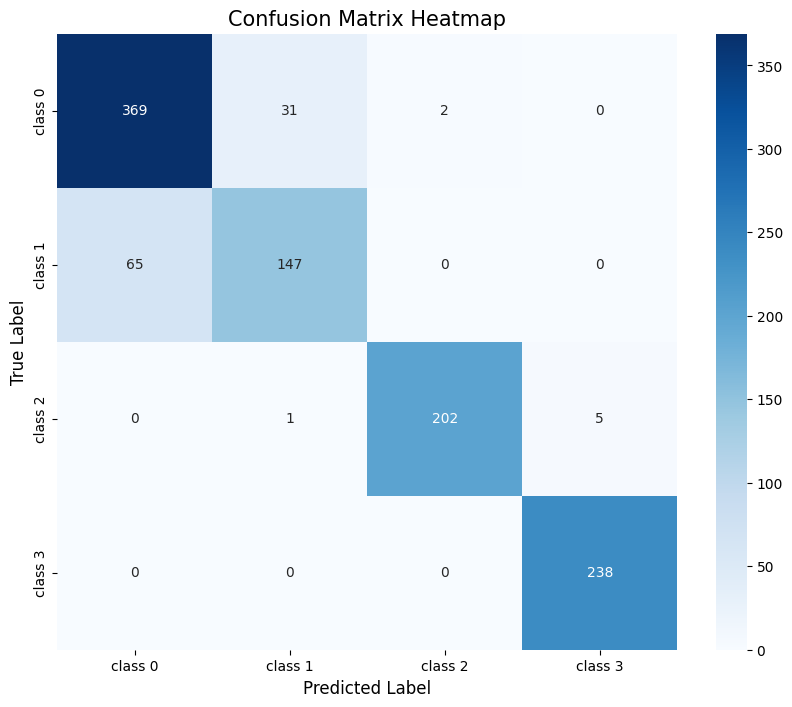

共发现 104 张错误分类图片，展示前 15 张...


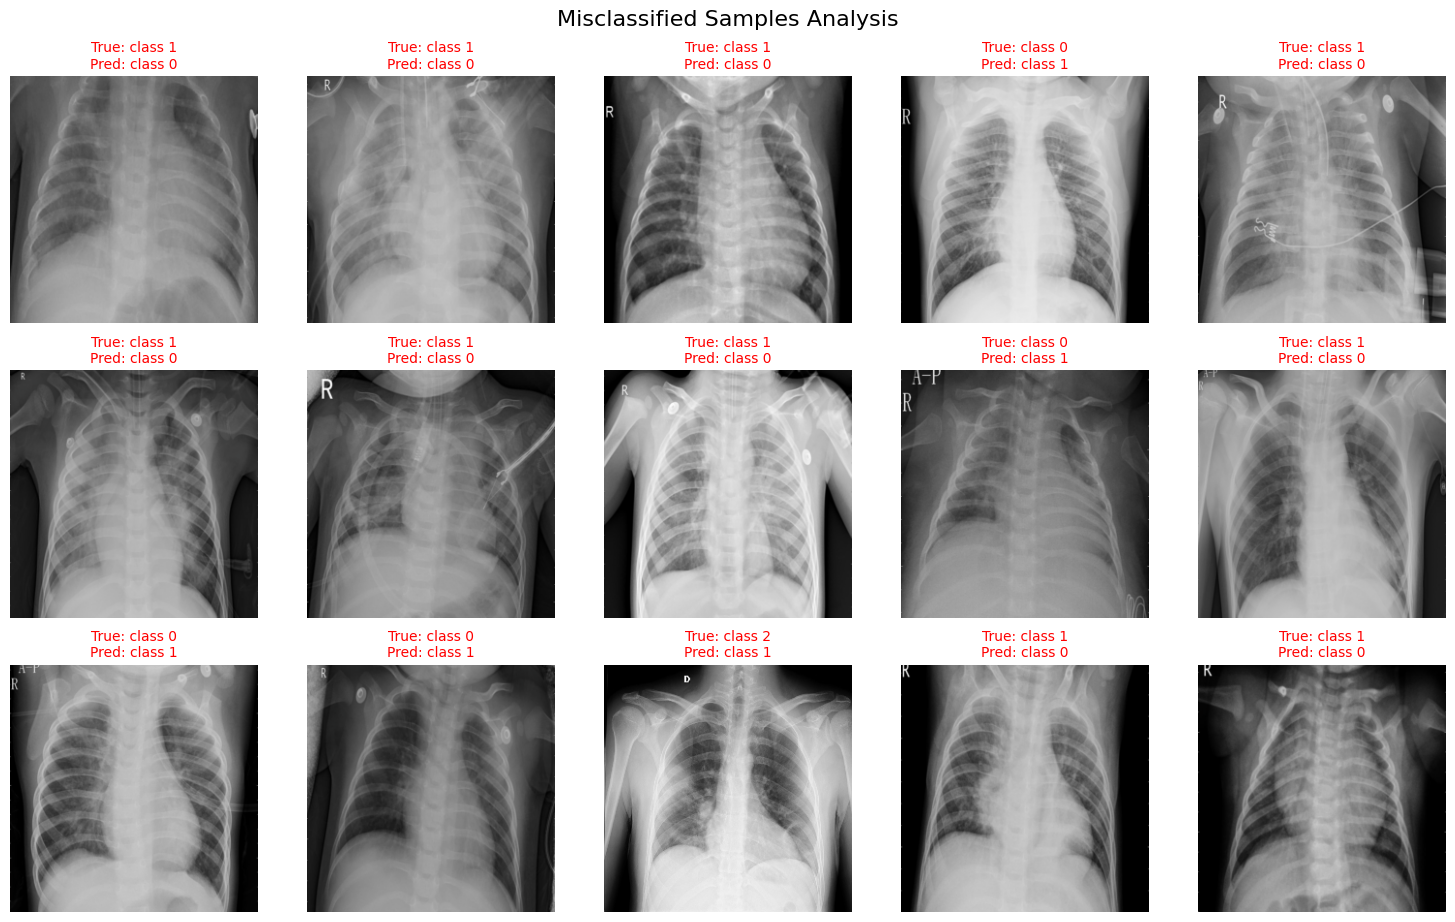

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import math

# ==========================================
# 1. 准备数据：获取所有预测结果
# ==========================================
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = [] # 存一部分图片用于展示
    
    print("正在收集预测数据...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
            
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 收集图片用于可视化 (只存 CPU 上的 Tensor)
            # 这是一个简单的去归一化操作，为了显示好看
            # 假设 mean=[0.485, ...] std=[0.229, ...]
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
            imgs_unnorm = images * std + mean
            all_images.extend(imgs_unnorm.cpu())
            
    return np.array(all_preds), np.array(all_labels), all_images

# 获取数据
preds, targets, images = get_all_predictions(model, test_loader, CONFIG['device'])

# 获取类别名称
try:
    if 'full_train_ds' in globals(): class_names = full_train_ds.classes
    elif 'full_dataset' in globals(): class_names = full_dataset.classes
    else: class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]
except:
    class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]

# ==========================================
# 2. 绘制混淆矩阵热力图
# ==========================================
plt.figure(figsize=(10, 8))
cm = confusion_matrix(targets, preds)

# 使用 Seaborn 画热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix Heatmap', fontsize=15)
plt.show()

# ==========================================
# 3. 展示 "错题本" (Misclassified Images)
# ==========================================
def show_misclassified(preds, targets, images, class_names, num_show=10):
    # 找到所有预测错误的索引
    mis_indices = np.where(preds != targets)[0]
    
    if len(mis_indices) == 0:
        print("🎉 太棒了！没有预测错误的图片。")
        return
    
    print(f"共发现 {len(mis_indices)} 张错误分类图片，展示前 {num_show} 张...")
    
    # 随机打乱一下，看看不同的错题
    np.random.shuffle(mis_indices)
    show_indices = mis_indices[:num_show]
    
    cols = 5
    rows = math.ceil(len(show_indices) / cols)
    
    plt.figure(figsize=(15, 3 * rows))
    
    for i, idx in enumerate(show_indices):
        img_tensor = images[idx]
        pred_label = class_names[preds[idx]]
        true_label = class_names[targets[idx]]
        
        # Tensor -> Numpy -> Transpose [C,H,W] to [H,W,C]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1) # 确保颜色范围正确
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np)
        
        # 标题：红色显示预测错的，绿色显示真实的
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='red', fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.suptitle("Misclassified Samples Analysis", fontsize=16, y=1.02)
    plt.show()

# 执行展示
show_misclassified(preds, targets, images, class_names, num_show=15)

正在准备数据 (当前 sklearn 版本: 1.7.2)...
原始特征形状: (1060, 8, 8, 768)
⚠️ 检测到特征维度为 4维 (如 [B, H, W, C])，t-SNE 需要 2维。
正在进行展平处理 (Flatten)...
✅ 展平完成！新形状: (1060, 49152)
正在进行 t-SNE 降维 (这可能需要几分钟)...
正在绘图...


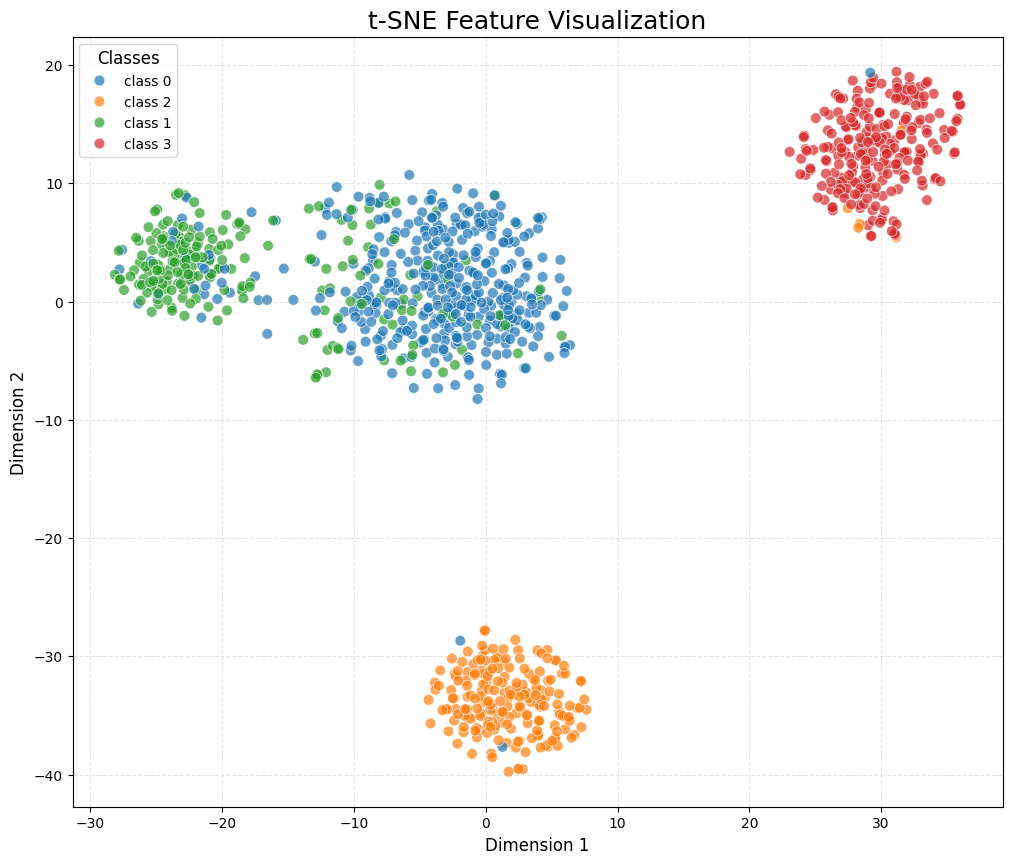

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from tqdm import tqdm

# ==========================================
# 1. 特征提取器 (保持不变，无需修改)
# ==========================================
# (为了代码完整性，保留这部分定义，确保你能直接运行)
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.features = []
        self.hook = None
    def _hook_fn(self, module, input, output):
        self.features.append(input[0].cpu().detach().numpy())
    def register_hook(self):
        target_layer = self.model.base_model.model.head
        self.hook = target_layer.register_forward_hook(self._hook_fn)
    def remove_hook(self):
        if self.hook: self.hook.remove()

def extract_features(model, loader, device):
    print("正在提取高维特征...")
    extractor = FeatureExtractor(model)
    extractor.register_hook()
    model.eval()
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting"):
            images = images.to(device)
            with torch.amp.autocast('cuda', dtype=torch.float16):
                _ = model(images)
            all_labels.extend(labels.numpy())
    extractor.remove_hook()
    features = np.concatenate(extractor.features, axis=0)
    labels = np.array(all_labels)
    print(f"✅ 特征提取完成！特征矩阵形状: {features.shape}")
    return features, labels




# ==========================================
def plot_tsne_final(features, labels, class_names):
    print(f"正在准备数据 (当前 sklearn 版本: {sklearn.__version__})...")
    print(f"原始特征形状: {features.shape}")
    
    # --------------------------------------
    # 【核心修复】自动处理多维数据
    # --------------------------------------
    if features.ndim > 2:
        print(f"⚠️ 检测到特征维度为 {features.ndim}维 (如 [B, H, W, C])，t-SNE 需要 2维。")
        print("正在进行展平处理 (Flatten)...")
        
        # 方法：保留第0维(样本数)，把后面所有的维度拉直成一条
        # 例如: [100, 8, 8, 768] -> [100, 49152]
        features = features.reshape(features.shape[0], -1)
        print(f"✅ 展平完成！新形状: {features.shape}")
    
    print("正在进行 t-SNE 降维 (这可能需要几分钟)...")
    
    try:
        # 极简参数，确保兼容性
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        features_2d = tsne.fit_transform(features)
    except Exception as e:
        print(f"❌ 降维依然报错: {e}")
        return

    print("正在绘图...")
    plt.figure(figsize=(12, 10))
    
    scatter = sns.scatterplot(
        x=features_2d[:, 0], 
        y=features_2d[:, 1], 
        hue=[class_names[i] for i in labels], 
        palette="tab10",
        s=60,      
        alpha=0.7, 
        edgecolor='w'
    )
    
    plt.title(f"t-SNE Feature Visualization", fontsize=18)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Classes", title_fontsize=12, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

# ==========================================
# 3. 执行
# ==========================================
# 获取类别名称
try:
    if 'full_train_ds' in globals(): class_names = full_train_ds.classes
    elif 'full_dataset' in globals(): class_names = full_dataset.classes
    else: class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]
except:
    class_names = [f"Class {i}" for i in range(CONFIG['num_classes'])]

# 1. 检查数据是否存在，不存在则报错提醒
if 'features' not in globals():
    print("⚠️ 内存中没找到 features 变量，请先运行上一步的 extract_features 函数！")
else:
    # 2. 绘图
    plot_tsne_final(features, labels, class_names)

正在分析图片: D:\IT\CODE\JUPYTER\ConvNeXt_V2\data\class 1\544.jpeg


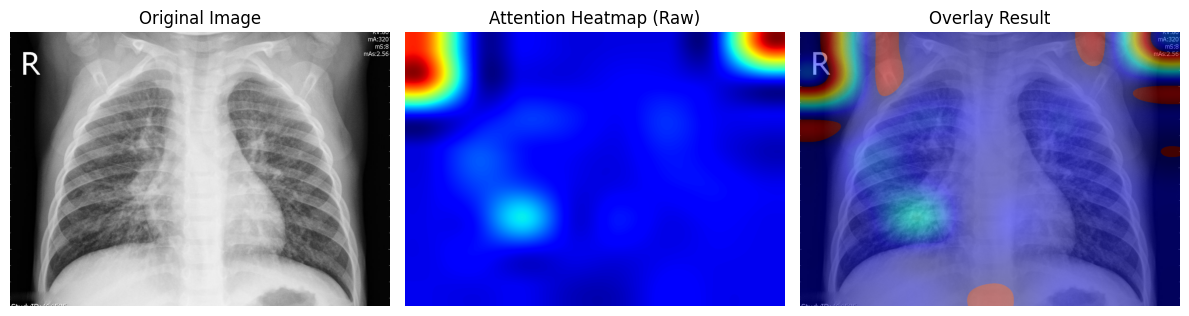

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms

# ==========================================
# 1. 定义 Hook 类 (用于抓取中间层特征)
# ==========================================
class FeatureExtractorHook:
    def __init__(self):
        self.features = None
        self.hook = None

    def _hook_fn(self, module, input, output):
        # output 是该层的输出特征图
        # 对于 Swin 最后一层，形状通常是 [Batch, L, C] (L=H*W)
        self.features = output.detach()

    def register(self, layer):
        # 注册钩子到指定层
        self.hook = layer.register_forward_hook(self._hook_fn)

    def remove(self):
        # 移除钩子
        if self.hook:
            self.hook.remove()

# ==========================================
# 2. 核心函数：生成注意力热力图 (修复版)
# ==========================================
def generate_attention_map(model, img_tensor, device):
    model.eval()
    
    # --- A. 设置钩子 ---
    target_layer = model.base_model.model.norm
    extractor = FeatureExtractorHook()
    extractor.register(target_layer)
    
    # --- B. 前向传播 ---
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        with torch.amp.autocast('cuda', dtype=torch.float16):
            _ = model(img_tensor)
            
    extractor.remove() 
    
    # --- C. 处理特征 (智能修复维度问题) ---
    # features raw shape: [Batch, ...] -> 取第一个样本
    features = extractor.features[0] 
    
    # 【核心修复逻辑】
    if features.ndim == 3:
        # 情况 A: 已经是 [H, W, C] (比如 [8, 8, 768]) -> 直接用！
        H, W, C = features.shape
    elif features.ndim == 2:
        # 情况 B: 是 [L, C] (比如 [64, 768]) -> 需要 reshape
        L, C = features.shape
        H = W = int(L ** 0.5)
        features = features.reshape(H, W, C)
    else:
        raise ValueError(f"无法识别的特征维度: {features.shape}")

    # 计算注意力强度 (在通道维度 C 上取平均)
    # features shape 现在保证是 [H, W, C]
    # mean(dim=2) 后变成 [H, W]
    attention_map = torch.mean(features, dim=2) 
    
    # 归一化到 [0, 1]
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / (attention_map.max() + 1e-8)
    
    return attention_map.cpu().numpy()
# ==========================================
# 3. 可视化绘图函数
# ==========================================
def visualize_attention(model, img_path, val_transforms, device):
    # A. 准备图像
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = val_transforms(img_pil).unsqueeze(0) # [1, C, H, W]
    
    # B. 生成 Attention Map
    att_map_small = generate_attention_map(model, img_tensor, device)
    
    # C. 图像后处理
    img_np = np.array(img_pil)
    orig_H, orig_W = img_np.shape[:2]
    
    # 将微小的注意力图 (如 8x8) 放大到原图尺寸 (如 256x256)
    att_map_resized = cv2.resize(att_map_small, (orig_W, orig_H), interpolation=cv2.INTER_CUBIC)
    
    # 将热力图应用颜色映射 (使得高亮区域呈红色/黄色)
    heatmap = cv2.applyColorMap(np.uint8(256 * att_map_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # 转回 RGB
    
    # 将热力图与原图叠加
    alpha = 0.5 # 透明度
    overlay = cv2.addWeighted(img_np, 1-alpha, heatmap, alpha, 0)
    
    # D. 绘图展示
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_pil)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(att_map_resized, cmap='jet')
    plt.title("Attention Heatmap (Raw)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay Result")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 执行可视化
# ==========================================
# 确保 val_transforms 已经定义 (如果你没运行前面的代码，需要补上)
if 'val_transforms' not in globals():
    val_transforms = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# 从测试集中随机选一张图，或者手动指定一张图的路径
try:
    

    found = False
    for idx in test_dataset.indices:
        path, label = full_dataset.samples[idx]
        if label == 1: # 找一张 Class 1 的图
            sample_img_path = path
            found = True
            break
    if not found: sample_img_path = test_dataset.dataset.samples[test_dataset.indices[0]][0]

    print(f"正在分析图片: {sample_img_path}")
    visualize_attention(model, sample_img_path, val_transforms, CONFIG['device'])

except Exception as e:
    print(f"出错啦: {e}")
    import traceback
    traceback.print_exc()

d:\IT\CONDA\envs\SV2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在重新加载 LoRA 模型...
✅ 权重加载成功！
正在分析图片: D:/IT/CODE/JUPYTER/ConvNeXt_V2/data\class 1\1.jpeg


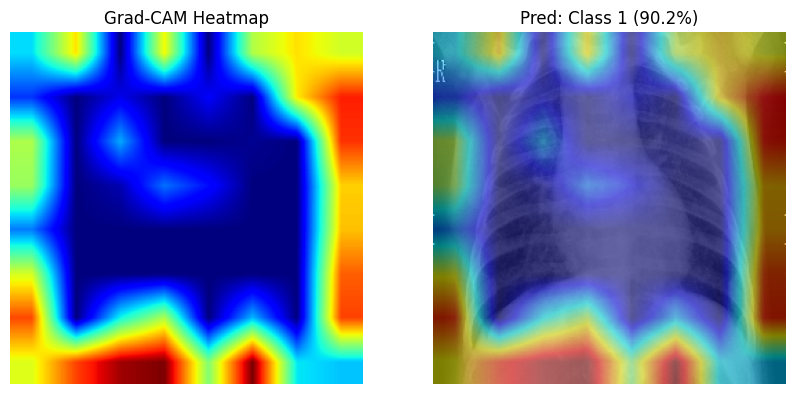

In [1]:
import torch
import torchvision.transforms as transforms
import os
import timm
from peft import LoraConfig, get_peft_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ==========================================
# 1. 补上缺失的配置 (CONFIG)
# ==========================================
CONFIG = {
    "num_classes": 4,          # 4类
    "img_size": 256,           # 分辨率
    "batch_size": 32,
    "data_dir": "D:/IT/CODE/JUPYTER/ConvNeXt_V2/data", # 你的数据路径
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# ==========================================
# 2. 补上 Transforms
# ==========================================
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==========================================
# 3. 重新加载模型 (防止 model 也没定义)
# ==========================================
def load_trained_model():
    print("正在重新加载 LoRA 模型...")
    # A. 基础模型
    base_model = timm.create_model(
        'swinv2_tiny_window16_256', 
        pretrained=False, 
        num_classes=CONFIG['num_classes']
    )
    # B. LoRA 配置
    peft_config = LoraConfig(
        r=16, lora_alpha=16, target_modules=["qkv", "proj", "fc1", "fc2"], 
        lora_dropout=0.1, bias="none", modules_to_save=["head"] 
    )
    # C. 包装
    model = get_peft_model(base_model, peft_config)
    model.to(CONFIG['device'])
    
    # D. 加载权重
    weight_path = "best_model_lora.pth"
    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path, map_location=CONFIG['device']), strict=False)
        print("✅ 权重加载成功！")
    else:
        print(f"⚠️ 警告：没找到 {weight_path}，将使用随机权重（仅演示用）")
    
    return model

# 如果内存里没有 model，就加载一个
if 'model' not in globals():
    model = load_trained_model()
    model.eval()

# ==========================================
# 4. Grad-CAM 核心逻辑
# ==========================================
def swin_reshape_transform(tensor):
    if len(tensor.shape) == 4: return tensor.permute(0, 3, 1, 2)
    elif len(tensor.shape) == 3:
        B, L, C = tensor.shape
        H = W = int(L ** 0.5)
        return tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    return tensor

def visualize_gradcam(model, img_path, device):
    # --- A. 准备 Grad-CAM ---
    try:
        target_layers = [model.base_model.model.layers[-1].blocks[-1].norm1]
    except:
        target_layers = [model.base_model.model.norm]

    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=swin_reshape_transform)
    
    # --- B. 处理图片 ---
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = val_transforms(img_pil).unsqueeze(0).to(device)
    
    # --- C. 生成热力图 ---
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
    
    # --- D. 绘图 ---
    img_np = np.array(img_pil) / 255.0
    img_np = cv2.resize(img_np, (256, 256))
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    
    # 获取预测
    with torch.no_grad():
        with torch.amp.autocast('cuda', dtype=torch.float16):
            output = model(input_tensor)
            pred_idx = output.argmax(dim=1).item()
            conf = output.softmax(dim=1)[0][pred_idx].item()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Pred: Class {pred_idx} ({conf:.1%})")
    plt.axis('off')
    plt.show()

# ==========================================
# 5. 执行 (手动指定一张图)
# ==========================================
# 由于 test_dataset 可能也丢失了，我们直接手动指定一张图来测试
# 请去你的文件夹里随便找一张图的路径，填在下面：
# 例如：D:/IT/CODE/JUPYTER/ConvNeXt_V2/data/class 1/xxxx.jpg

# 这里我写了一个自动搜索代码，试图从你的 data_dir 里找一张图
import glob
search_path = os.path.join(CONFIG['data_dir'], "class 1", "*.*") # 找 Class 1 的图
found_files = glob.glob(search_path)

if len(found_files) > 0:
    sample_path = found_files[0] # 取第一张
    print(f"正在分析图片: {sample_path}")
    visualize_gradcam(model, sample_path, CONFIG['device'])
else:
    print("⚠️ 没找到图片，请手动修改 sample_path 变量为具体的图片路径！")